
#  <br/><br/><br/> An integrated framework for building a DNN based recommender engine using the developed package

### *Fan Xia*

#### Last edited on 06/2023 by Fan X.

### Introduction
#### An integrated framework for designing and optimizing a recommendation algorithm is presented using the developed library. Here, I demostrate the pipeline by using the Bayesian Personalized Ranking (BPR) algorithm on MovieLens latest small dataset.

### Import required packages

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

### Data preparation
#### Data preparation includes reading raw data from disk that are used for model building, checking missing data, cleanning up duplicated and abnormal data and creating cleaned data for recommender system.

In [3]:
# Load data from disk
filename = '../data/ml_small/ratings.csv'
raw_data = pd.read_csv(filename, encoding='latin-1')

raw_data

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [4]:
# Check the shape of data frame
raw_data.shape

(100004, 4)

In [5]:
# Check number of users in data
raw_data['userId'].nunique()

671

In [6]:
# Check number of items in data
raw_data['movieId'].nunique()

9066

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [8]:
# Check if has missing data
raw_data.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [9]:
# Summarize raw dataset
raw_data.count()

userId       100004
movieId      100004
rating       100004
timestamp    100004
dtype: int64

In [10]:
raw_data.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [11]:
# Check if the data have duplicates
raw_data[raw_data.duplicated()].count()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [12]:
# Create cleaned data:
# 1. Drop duplicates in the data frame (No present)
# 2. Drop the records with negtive 'rating' value (No present)
# 3. Drop the column 'timestamp'
clean_data = raw_data.drop('timestamp', axis=1).drop_duplicates().reset_index(drop=True)
clean_data

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


### Data Analysis and Refinement
#### Data refinement ensures the data is relevant and categorized so the users can get meaningful results.

In [13]:
# Check the number of items by an user
user_count = pd.DataFrame(clean_data.groupby('userId')['movieId'].nunique())
user_count.describe()

,movieId
count,671.000000
mean,149.037258
std,231.226948
min,20.000000
25%,37.000000
50%,71.000000
75%,161.000000
max,2391.000000


<Axes: >

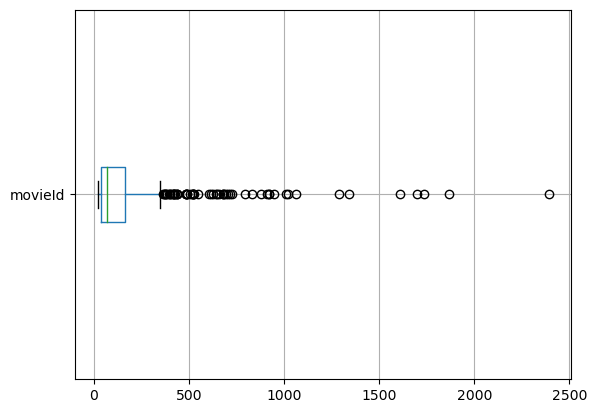

In [14]:
# Check outliers in user data
user_count.boxplot(column=['movieId'], vert=False)

array([[<Axes: title={'center': 'movieId'}>]], dtype=object)

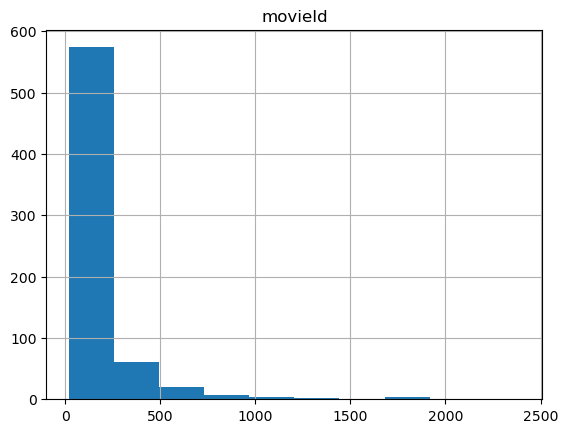

In [15]:
# Distribution of number of items per user
user_count.hist()

In [16]:
# Create active user data frame
active_user = user_count[(user_count['movieId'] >= 1) & (user_count['movieId'] <= 2500)]
active_user

,movieId
userId,
1,20
2,76
3,51
4,204
5,100
...,...
667,68
668,20
669,37


In [17]:
# Check the number of users who use the same item
item_count = pd.DataFrame(clean_data.groupby('movieId')['userId'].nunique())
item_count.describe()

,userId
count,9066.000000
mean,11.030664
std,24.050800
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,341.000000


<Axes: >

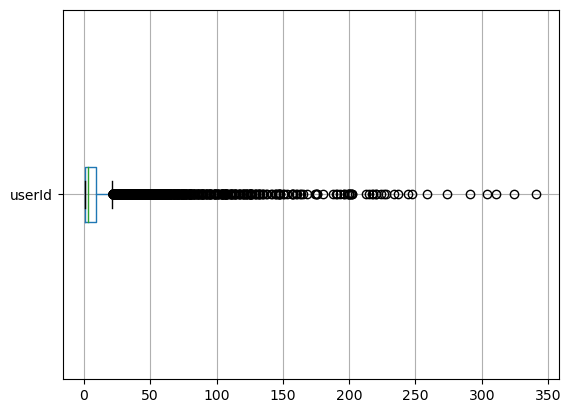

In [18]:
# Check outliers in item data
item_count.boxplot(column=['userId'], vert=False)

array([[<Axes: title={'center': 'userId'}>]], dtype=object)

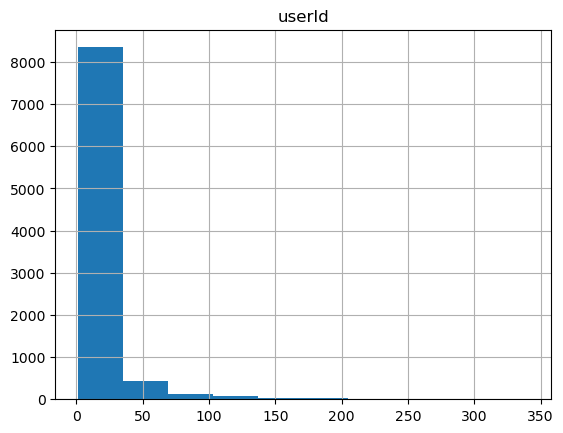

In [19]:
# Distribution of number of users per item
item_count.hist()

#### By EDA above, the average sparsity along rows, i.e. 149/9066 = 0.016 is close to that along columns, i.e. 11/671=0.016.

,rating,perc
5.0,15095,15.094396
4.5,7723,7.722691
4.0,28750,28.748850
3.5,10538,10.537578
3.0,20064,20.063197
2.5,4449,4.448822
2.0,7271,7.270709
1.5,1687,1.686933
1.0,3326,3.325867
0.5,1101,1.100956


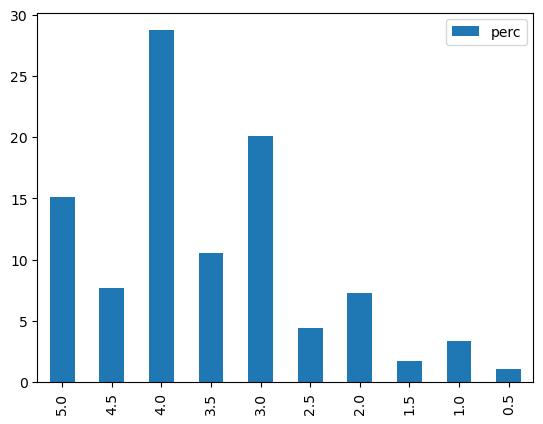

In [20]:
# Distribution of all ratings
rating_data = pd.DataFrame(clean_data['rating'].value_counts().sort_index(ascending=False))
samples = rating_data['rating'].sum()
rating_data['perc'] = rating_data['rating']/samples*100.0
rating_data.plot.bar(y='perc')
rating_data

,userId,perc
rating,,
5.0,644,95.976155
4.5,339,50.521610
4.0,669,99.701937
3.5,346,51.564829
3.0,655,97.615499
2.5,286,42.622951
2.0,554,82.563338
1.5,199,29.657228
1.0,409,60.953800


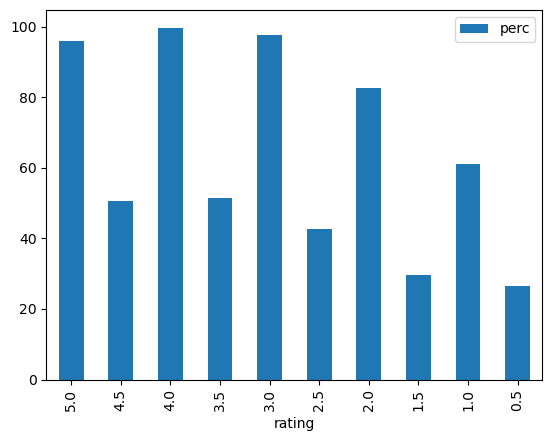

In [21]:
# Distribution of users with the same rating (user's behavior)
rating_user = pd.DataFrame(clean_data.groupby('rating')['userId'].nunique().sort_index(ascending=False))
samples = clean_data['userId'].nunique()
rating_user['perc'] = rating_user['userId']/samples*100.0
rating_user.plot.bar(y='perc')
rating_user

,movieId,perc
rating,,
5.0,3127,34.491507
4.5,2454,27.068167
4.0,5141,56.706375
3.5,3612,39.841165
3.0,4771,52.625193
2.5,2409,26.571807
2.0,3130,34.524597
1.5,1204,13.280388
1.0,1959,21.608206


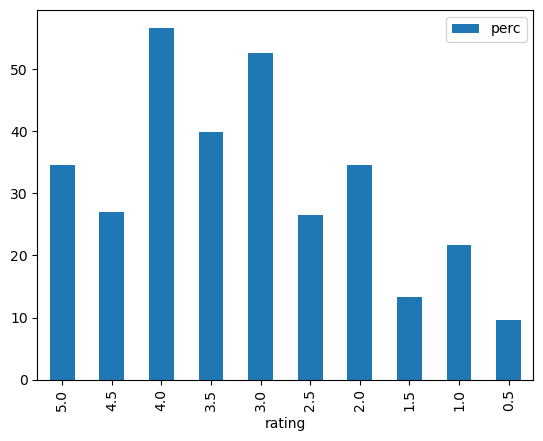

In [22]:
# Distribution of items with the same rating
rating_item = pd.DataFrame(clean_data.groupby('rating')['movieId'].nunique().sort_index(ascending=False))
samples = clean_data['movieId'].nunique()
rating_item['perc'] = rating_item['movieId']/samples*100.0
rating_item.plot.bar(y='perc')
rating_item

In [23]:
# Create refined data
data = clean_data[clean_data['userId'].isin(active_user.index)].reset_index(drop=True)
data

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


In [24]:
# Build popularity rankings data frame
ranking_data = pd.DataFrame(data['movieId'].value_counts().sort_index(ascending=True)).reset_index(drop=False)
ranking_data['rank'] = ranking_data.index + 1
ranking_data.set_index("index", drop=True, inplace=True)
ranking_data = ranking_data.drop('movieId', axis=1)

ranking_data

,rank
index,
1,1
2,2
3,3
4,4
5,5
...,...
161944,9062
162376,9063
162542,9064


In [25]:
# Build popularity ranking dictionary
rankings = ranking_data.T.to_dict('list')
for k, v in rankings.items():
    rankings[k] = int(v[0])
rankings[162672]

9065

In [26]:
# Build catalog items as type of list
catalog = data['movieId'].unique().tolist()
catalog[0]

31

In [41]:
# Build item ID to item relations
import csv

table = {}
filename = '../data/ml_small/movies.csv'
with open(filename, newline='', encoding='ISO-8859-1') as file:
    reader = csv.reader(file)
    next(reader)
    for line in reader:
        iid = int(line[0])
        tag = line[1]
        table[iid] = tag

### Load data into Surprise library

In [27]:
from surprise import Dataset
from surprise import Reader

min_rating = data['rating'].min()
max_rating = data['rating'].max()
print("Set rating scale to: ", min_rating, max_rating)

reader = Reader(rating_scale=(min_rating, max_rating))
ratings = Dataset.load_from_df(data, reader)

Set rating scale to:  0.5 5.0


### Build the BPR recommender engine

In [28]:
# Declare the local path of the package
import sys
sys.path.append(r'../src/mypkg')

### Tune & Evaluate RBM recommenders using *mypkg* package

In [29]:
import random
np.random.seed(0)
random.seed(0)

In [31]:
# Load the module
from bprs import BPR
from comparer import comparer

# Construct a comparer class
cmp = comparer(data=ratings, rankings=rankings, catalog=catalog)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [32]:
# Build BPR recommender with default parameters
bpr0 = BPR(verbose=False)
# Build BPR recommender with tuned parameters
bpr1 = BPR(factor=100, epochs=10, lr=0.0001, verbose=False)

In [33]:
# Reset algorithms queue
cmp.reset()

# Add BPR recommenders
cmp.addAlgorithm(bpr0, "BPR0")
cmp.addAlgorithm(bpr1, "BPR1")

In [34]:
# Enable top-n ranking metrics
metrics = ['HR', 'MRR', 'Cov', 'Div', 'Nov']
cmp.doTopN(n=10, enable=True)

In [37]:
# Compare performance of recommenders
result = cmp.compare(metrics=metrics)

compare: evaluating BPR0...
bpr: training...


100%|██████████████████████████████| 1/1 [00:06<00:00,  6.43s/epoch, loss=0.614]


eval: hit-rate and ranking metrics...
bpr: training...


100%|██████████████████████████████| 1/1 [00:06<00:00,  6.67s/epoch, loss=0.623]


eval: coverage and novelty metrics...
Computing the cosine similarity matrix...
Done computing similarity matrix.
eval: complete [BPR0]
compare: evaluating BPR1...
bpr: training...


100%|████████████████████████████| 10/10 [01:47<00:00, 10.73s/epoch, loss=0.325]


eval: hit-rate and ranking metrics...
bpr: training...


100%|████████████████████████████| 10/10 [01:50<00:00, 11.02s/epoch, loss=0.326]


eval: coverage and novelty metrics...
Computing the cosine similarity matrix...
Done computing similarity matrix.
eval: complete [BPR1]


In [38]:
# Summarize performance of recommenders
cmp.summary(result)

Engine    HR        MRR       Cov       Div       Nov       
BPR0      0.0969    0.0392    0.0147    0.038     801.2246  
BPR1      0.1073    0.0469    0.0141    0.0351    758.5335  


In [42]:
# Compare top-n recommendations of user
cmp.sampleTopN(table, user=85)


sample: selecting recommender algorithm:  BPR0
bpr: training...


100%|██████████████████████████████| 1/1 [00:06<00:00,  6.64s/epoch, loss=0.613]


sample: top-n recommendations for user: 85
Star Wars: Episode IV - A New Hope (1977)
Toy Story (1995)
Men in Black (a.k.a. MIB) (1997)
Matrix, The (1999)
Star Wars: Episode VI - Return of the Jedi (1983)
Fight Club (1999)
Sixth Sense, The (1999)
Star Wars: Episode V - The Empire Strikes Back (1980)
Apollo 13 (1995)
Lord of the Rings: The Two Towers, The (2002)

sample: selecting recommender algorithm:  BPR1
bpr: training...


100%|█████████████████████████████| 10/10 [01:51<00:00, 11.16s/epoch, loss=0.32]


sample: top-n recommendations for user: 85
Star Wars: Episode IV - A New Hope (1977)
Toy Story (1995)
Usual Suspects, The (1995)
Matrix, The (1999)
Star Wars: Episode V - The Empire Strikes Back (1980)
Star Wars: Episode VI - Return of the Jedi (1983)
American Beauty (1999)
Back to the Future (1985)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Independence Day (a.k.a. ID4) (1996)


### Deploy the BPR recommender engine using *mypkg* package

In [43]:
# Specify a customer ID
user = 85

In [44]:
from deployer import deployer
bpr = BPR()
dpr = deployer(bpr, "BPR")
dpr.build(ratings)
top = dpr.get(table, user)

bpr: initializing...


100%|█████████████████████████████████████████| 671/671 [01:00<00:00, 11.13it/s]


bpr: training...


100%|██████████████████████████████| 1/1 [00:06<00:00,  6.99s/epoch, loss=0.606]


bpr: predicting...


100%|████████████████████████████████████████| 671/671 [00:01<00:00, 378.81it/s]


BPR recommendations for user: 85
Star Wars: Episode IV - A New Hope (1977)
Fargo (1996)
Star Wars: Episode VI - Return of the Jedi (1983)
Toy Story (1995)
Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Independence Day (a.k.a. ID4) (1996)
Matrix, The (1999)
Apollo 13 (1995)
Groundhog Day (1993)
Lord of the Rings: The Return of the King, The (2003)


In [45]:
bpr.summary()

bpr: total parameters: 486850
bpr: trainable parameters: 486850
bpr: non-trainable parameters: 0
bpr: training data samples: 100004
bpr: bootstrapping samples: 9066 [9066]


### Supplementary function